<a href="https://colab.research.google.com/github/mforker/kaggle/blob/main/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [ ]:
print(df.shape)

(750000, 12)


In [ ]:
df = df.drop_duplicates()
print(df.shape)

(750000, 12)


In [ ]:
print(df.isna().sum())

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64


In [ ]:
df = df[~df['Number_of_Ads'].isna()]
print(df.shape)

(749999, 12)


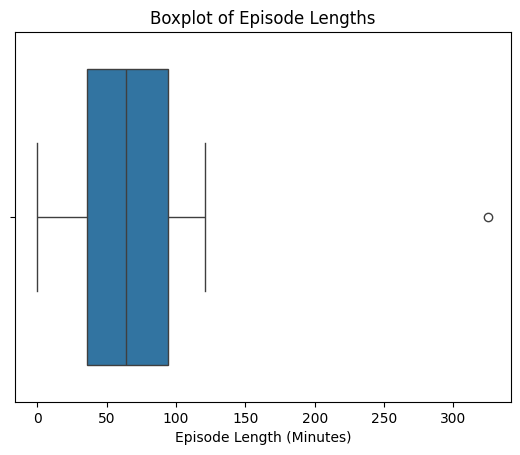

In [ ]:
sns.boxplot(x = df['Episode_Length_minutes'])
plt.xlabel('Episode Length (Minutes)')
plt.title('Boxplot of Episode Lengths')
plt.show()

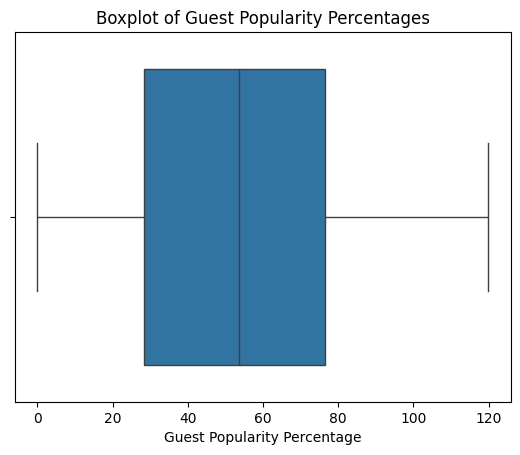

In [ ]:
sns.boxplot(x = df['Guest_Popularity_percentage'])
plt.xlabel('Guest Popularity Percentage')
plt.title('Boxplot of Guest Popularity Percentages')
plt.show()

In [ ]:
q1 = df['Episode_Length_minutes'].quantile(0.25)
q3 = df['Episode_Length_minutes'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_nan = df[df['Episode_Length_minutes'].isna()]
df = df[~df['Episode_Length_minutes'].isna()]
df = df[(df['Episode_Length_minutes'] >= lower_bound) & (df['Episode_Length_minutes'] <= upper_bound)]
df = pd.concat([df,df_nan])
print(df.shape)

(749998, 12)


In [ ]:
# imputing Episode Length Minutes
mean_len = df.groupby('Podcast_Name')['Episode_Length_minutes'].mean().reset_index(name = 'Mean_Dur')
mean_len_map = mean_len.set_index('Podcast_Name')['Mean_Dur'].to_dict()
mean_len_map


{"Athlete's Arena": 65.84145002666152,
 'Brain Boost': 63.45841916371799,
 'Business Briefs': 66.67273117600233,
 'Business Insights': 62.85052578646617,
 'Comedy Corner': 62.63431605846771,
 'Crime Chronicles': 66.09590660730763,
 'Criminal Minds': 61.44970857441532,
 'Current Affairs': 62.01022120059374,
 'Daily Digest': 65.28976221517944,
 'Detective Diaries': 65.8284852482099,
 'Digital Digest': 63.4173656755638,
 'Educational Nuggets': 65.06675002035371,
 'Fashion Forward': 64.62641731163349,
 'Finance Focus': 62.0513269868116,
 'Fitness First': 65.38452896585173,
 'Funny Folks': 63.73354234956822,
 'Gadget Geek': 65.03048366346326,
 'Game Day': 62.7135723936742,
 'Global News': 65.77577336517001,
 'Health Hour': 64.42347040587816,
 'Healthy Living': 64.53538735710995,
 'Home & Living': 66.50949387549903,
 'Humor Hub': 65.41717706239568,
 'Innovators': 64.52611539726462,
 'Joke Junction': 61.348252092201896,
 'Laugh Line': 63.03206505745214,
 'Learning Lab': 65.2761204178481,
 'Li

In [ ]:
df.loc[df['Episode_Length_minutes'].isna(),'Episode_Length_minutes'] = (df.loc[df['Episode_Length_minutes'].isna(),'Podcast_Name'].map(mean_len_map))
print(df.isna().sum())
df.loc[df['Podcast_Name']=='Music Matters',:]

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes              0
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       0
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
38,38,Music Matters,Episode 32,86.840000,Music,86.65,Thursday,Morning,28.27,1.0,Neutral,81.49839
64,64,Music Matters,Episode 69,81.130000,Music,66.37,Wednesday,Evening,97.43,1.0,Negative,55.97010
85,85,Music Matters,Episode 23,9.730000,Music,31.68,Tuesday,Morning,52.06,1.0,Neutral,6.01368
127,127,Music Matters,Episode 59,64.570000,Music,84.75,Thursday,Morning,NaN,1.0,Neutral,53.49181
209,209,Music Matters,Episode 21,85.180000,Music,85.61,Wednesday,Evening,96.45,1.0,Neutral,73.71758
...,...,...,...,...,...,...,...,...,...,...,...,...
745564,745564,Music Matters,Episode 45,65.192867,Music,71.76,Tuesday,Night,33.56,2.0,Negative,97.47198
745642,745642,Music Matters,Episode 69,65.192867,Music,23.22,Sunday,Afternoon,18.90,0.0,Negative,66.61818
748086,748086,Music Matters,Episode 85,65.192867,Music,41.10,Saturday,Afternoon,79.40,0.0,Positive,91.31101
749364,749364,Music Matters,Episode 34,65.192867,Music,76.19,Friday,Morning,99.08,3.0,Positive,51.55510


In [ ]:
pop_rating_gener = df.groupby('Genre')['Guest_Popularity_percentage'].mean().reset_index(name = 'Mean_Pop')
rating_map = pop_rating_gener.set_index('Genre')['Mean_Pop'].to_dict()
rating_map

{'Business': 51.22199563894205,
 'Comedy': 53.36126372340106,
 'Education': 52.3152052570545,
 'Health': 51.441919825348535,
 'Lifestyle': 51.757591048236094,
 'Music': 52.052459037467706,
 'News': 52.43683772161711,
 'Sports': 53.076813456170484,
 'Technology': 51.83673721373768,
 'True Crime': 52.71503734356076}

In [ ]:
df.loc[df['Guest_Popularity_percentage'].isna(),'Guest_Popularity_percentage'] = (df.loc[df['Guest_Popularity_percentage'].isna(),'Genre'].map(rating_map))
print(df.isna().sum())

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64
